# Heurística de consolidación

**Consideraciones**
- Cada camión límite de 8H
- Cada camión límite de 10T (10.000 kilos o cantidad)
- Atender a clientes premium primero, dps los otros pq tengo más tiempo
- Considerar que los camioneros paran??

Esto es diferente porque necesitamos las fechas de las ventas, pero se parece al trabajo de BDD de construccion_datos

### 1. Heurística para PMEDIAN

#### 1.1 Bases de datos

In [1]:
import pandas as pd
import numpy as np
import construccion_datos_2 as construccion_datos
from modelo_V_consolidacion import LocalizacionOptima #modelo_V_localizacion
import json

# Importación base de datos
bdd_categoria = "BDD_Bodegas_Categorizada.xlsx" # "BDD_Bodegas_Categorizada_proy.xlsx"
bdd_ventas = pd.read_excel(bdd_categoria)
bdd_bodegas = pd.read_excel("BDD_Bodegas.xlsx", sheet_name=2)
bdd_comunas = pd.read_excel("BDD_Bodegas.xlsx", sheet_name=3)
bdd_comuna_bodega = pd.read_excel("distancias_comunas_bodegas.xlsx")

# Pasamos la columna de fechas a formato de fechas
bdd_ventas['Fecha'] = pd.to_datetime(bdd_ventas['Fecha'])

# Agrupación de ventas por cliente y completar comuna
bdd_ventas_2 = bdd_ventas.merge(bdd_comunas, left_on='Comuna Despacho', right_on='Comuna')
bdd_ventas_2['Cantidad'] = bdd_ventas_2['Cantidad'].apply(lambda x: 0.01 if x == 0 else x)
bdd_ventas_2['Nuevo_ID'] = range(len(bdd_ventas_2))


dict_bodegas = bdd_bodegas.set_index('ID Bodega')[['LAT', 'LONG']].to_dict(orient='index') 
dict_ventas = bdd_ventas_2.set_index('Nuevo_ID')[['ID Cliente', 'Cantidad', 'Comuna Despacho', 'LAT', 'LON', 'ID Bodega Despacho', 'Categoria', 'Fecha']].to_dict(orient='index') 

In [2]:
#dict_ventas = construccion_datos.dict_ventas #Necesito la fecha!
dict_bodegas = construccion_datos.dict_bodegas
bdd_ventas_agrupadas = construccion_datos.bdd_ventas_agrupadas

In [3]:
# Para esto ocupamos el dict ventas agrupadas, para tener solo los clientes y las distancias entre ellos
dict_ventas_agrupadas = bdd_ventas_agrupadas.set_index('ID Cliente')[['Cantidad', 'Comuna Despacho', 'LAT', 'LON', 'ID Bodega Despacho', 'Categoria']].to_dict(orient='index') 

Necesito las distancias Manhattan entre clientes. Además incluyo clientes que tenían demanda acumulada 0

In [4]:
with open('d_manhattan_entre_clientes.json', 'r') as archivo_json:
    datos = json.load(archivo_json)

d_Manhattan_entre_comunas = datos

In [5]:
# Crear un diccionario para almacenar las distancias entre clientes
dict_distancias_entre_clientes = {}

# Iterar sobre cada cliente en dict_ventas_agrupadas
for cliente1, info1 in dict_ventas_agrupadas.items():
    comuna_cliente1 = info1["Comuna Despacho"]

    # Crear un subdiccionario para almacenar las distancias de cliente1 a otros clientes
    dict_distancias_entre_clientes[cliente1] = {}

    # Iterar sobre cada otro cliente en dict_ventas_agrupadas
    for cliente2, info2 in dict_ventas_agrupadas.items():
        comuna_cliente2 = info2["Comuna Despacho"]

        # Obtener la distancia entre las comunas de cliente1 y cliente2 del diccionario d_Manhattan_entre_clientes
        distancia = d_Manhattan_entre_comunas[comuna_cliente1][comuna_cliente2]

        # Almacenar la distancia en el diccionario dict_distancias_entre_clientes
        dict_distancias_entre_clientes[cliente1][cliente2] = distancia


In [6]:
d_Manhattan_entre_clientes = dict_distancias_entre_clientes

In [7]:
with open('d_manhattan.json', 'r') as archivo_json:
    d_Manhattan_bodega_cliente = json.load(archivo_json)

In [8]:
d_Manhattan_bodega_cliente_float = {}

for cliente, distancias in d_Manhattan_bodega_cliente.items():
    # Convertir los valores (distancias) a float
    distancias_float = {int(destino): float(distancia) for destino, distancia in distancias.items()}
    
    # Agregar al nuevo diccionario
    d_Manhattan_bodega_cliente_float[int(cliente)] = distancias_float


In [9]:
d_Manhattan_bodega_cliente = d_Manhattan_bodega_cliente_float

Corro modelo de optimización (se pueden cambiar los parámetros)

In [10]:
def solucion_p_median(p):
    # Crear una instancia de LocalizacionOptima
    modelo = LocalizacionOptima(p, construccion_datos.d_Manhattan)

    # Llamar al método que resuelve el modelo
    modelo.resolver()

    # Recuperar el diccionario solución
    diccionario_solucion = modelo.resultados

    return diccionario_solucion

#diccionario_solucion = solucion_p_median(10)

#### 1.2 Heurística 

Hacemos diccionario que tiene fecha y la info de los clientes de esa fecha

In [11]:
# Clientes por fecha
# Supongamos que 'diccionario' es tu diccionario con 66,000 filas

clientes_por_fecha_2 = {}

for cliente_id, cliente_info in dict_ventas.items():
    fecha = cliente_info['Fecha']
    
    # Si la fecha ya está en el diccionario, agregamos el cliente a la lista existente
    if fecha in clientes_por_fecha_2:
        clientes_por_fecha_2[fecha].append(cliente_info)
    else:
        # Si la fecha no está en el diccionario, creamos una nueva lista con este cliente
        clientes_por_fecha_2[fecha] = [cliente_info]

Calculamos el valor objetivo de la solución previa sin consolidación

In [12]:
def calcular_valor_objetivo_previo(diccionario_solucion, clientes_por_fecha_2, ida_o_vuelta):
    valor_objetivo_previo = 0

    if ida_o_vuelta == "ida":
        for fecha in clientes_por_fecha_2:
            for cliente in clientes_por_fecha_2[fecha]:
                valor_objetivo_previo += diccionario_solucion[cliente["ID Cliente"]]["Tiempo"] 

    elif ida_o_vuelta == "vuelta":
        for fecha in clientes_por_fecha_2:
            for cliente in clientes_por_fecha_2[fecha]:
                valor_objetivo_previo += diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]*2
    
    return valor_objetivo_previo

In [13]:
calcular_valor_objetivo_previo(solucion_p_median(10), clientes_por_fecha_2, "vuelta")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-21


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 31384 rows, 28540 columns and 85600 nonzeros
Model fingerprint: 0xea46b597
Variable types: 28530 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 31384 rows and 28540 columns
Presolve time: 0.06s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.08 seconds (0.03 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 116401 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.164005100000e+05, best bound 1.164005100000e+05, gap 0.0000%


119818.46133336831

Definimos los parámetros de la consolidación

In [14]:
# Es muy greedy, se puede mejorar

velocidad = 45
capacidad_maxima = 10000
tiempo_maximo = 8

In [15]:
# Función para verificar si cliente cabe en camión
def cabe_en_camion(camion, cliente):
    tiempo_a_cliente = d_Manhattan_entre_clientes[camion[2][-1]][cliente[1]] / velocidad  #aca podriamos hacer un 3-opt
    if camion[0] + cliente[0] <= capacidad_maxima and camion[1] + tiempo_a_cliente <= tiempo_maximo:
        return (True, tiempo_a_cliente)
    else:
        return (False, tiempo_a_cliente)

In [16]:
# Iteraciones
clientes_por_fecha = dict(clientes_por_fecha_2)

# La solución se guarda con diccionario por fecha
solucion_consolidacion = dict() 

Hacemos consolidación
- Revisa los clientes por fecha
- Primero revisa premium, luego gold y finalmente silver
- Por cada cliente, dentro de su categoria, revisa si cabe en un camion existente o crea uno nuevo (por capacidad y tiempo)

In [17]:
lista = [2481, 1782]

In [18]:
def consolidacion(clientes_por_fecha, diccionario_solucion):

    for fecha in clientes_por_fecha: 
        solucion_fecha = list()
        for cliente in clientes_por_fecha[fecha]:
            if cliente["ID Cliente"] not in lista:
                if cliente['Categoria'] == "Premium":
                    
                    # Si es que no es primer cliente
                    if len(solucion_fecha) != 0:
                        cupo = False
                        for indice, camion in enumerate(solucion_fecha):

                            # Si cabe en algun camion, lo agrego
                            cliente_iteracion = [cliente["Cantidad"], cliente["ID Cliente"]]
                            cabe = cabe_en_camion(camion, cliente_iteracion)

                            if cabe[0] and diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"] == camion[2][0]:
                                solucion_fecha[indice][0] += cliente["Cantidad"]
                                solucion_fecha[indice][1] += cabe[1]
                                solucion_fecha[indice][2].append(cliente["ID Cliente"])
                                cupo = True
                                break
                        
                        if not cupo:
                            tiempo = diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]
                            solucion_fecha.append([cliente["Cantidad"], tiempo, [diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"], cliente["ID Cliente"]] ])
                    
                    # Si es que es primer cliente
                    else:
                        # Creo camión ############
                        tiempo = diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]
                        solucion_fecha.append([cliente["Cantidad"], tiempo, [diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"], cliente["ID Cliente"]] ])
            
        for cliente in clientes_por_fecha[fecha]:
            if cliente["ID Cliente"] not in lista:
                if cliente['Categoria'] == "Gold":
                    # Si es que no es primer cliente

                    if len(solucion_fecha) != 0:
                        cupo = False
                        for indice, camion in enumerate(solucion_fecha):

                            # Si cabe en algun camion, lo agrego
                            cliente_iteracion = [cliente["Cantidad"], cliente["ID Cliente"]]
                            cabe = cabe_en_camion(camion, cliente_iteracion)

                            if cabe[0] and diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"] == camion[2][0]:
                                solucion_fecha[indice][0] += cliente["Cantidad"]
                                solucion_fecha[indice][1] += cabe[1]
                                solucion_fecha[indice][2].append(cliente["ID Cliente"])
                                
                                cupo = True
                                break
                        
                        if not cupo:
                            tiempo = diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]
                            solucion_fecha.append([cliente["Cantidad"], tiempo, [diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"], cliente["ID Cliente"]] ])
                    
                    # Si es que es primer cliente
                    else:
                        # Creo camión ############
                        tiempo = diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]
                        solucion_fecha.append([cliente["Cantidad"], tiempo, [diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"], cliente["ID Cliente"]] ])

        for cliente in clientes_por_fecha[fecha]:
            if cliente["ID Cliente"] not in lista:
                if cliente['Categoria'] == "Silver":

                    # Si es que no es primer cliente
                    if len(solucion_fecha) != 0:
                        cupo = False
                        for indice, camion in enumerate(solucion_fecha):

                            # Si cabe en algun camion, lo agrego
                            cliente_iteracion = [cliente["Cantidad"], cliente["ID Cliente"]]
                            cabe = cabe_en_camion(camion, cliente_iteracion)

                            if cabe[0] and diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"] == camion[2][0]:
                                solucion_fecha[indice][0] +=  cliente["Cantidad"]
                                solucion_fecha[indice][1] += cabe[1]
                                solucion_fecha[indice][2].append(cliente["ID Cliente"])
                                cupo = True
                                break
                        
                        if not cupo:
                            tiempo = diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]
                            solucion_fecha.append([cliente["Cantidad"], tiempo, [diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"], cliente["ID Cliente"]] ])
                    
                    # Si es que es primer cliente
                    else:
                        # Creo camión ############
                        tiempo = diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]
                        solucion_fecha.append([cliente["Cantidad"], tiempo, [diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"], cliente["ID Cliente"]] ])
                
        solucion_consolidacion[fecha] = solucion_fecha   

    return solucion_consolidacion

In [55]:
solucion_consolidacion 

{Timestamp('2017-01-03 00:00:00'): [[301.756304,
   7.296920636960536,
   [4, 343, 387, 145, 464, 418, 656, 513]],
  [381.87328, 7.834218246839344, [4, 105, 495, 652, 765, 768, 1144]],
  [134.31484799999998, 7.438804383810487, [8, 335, 312, 225, 580]],
  [57.473176, 2.0900816708782766, [1, 419, 892]],
  [300.52446399999997, 7.323206375508644, [4, 881, 1017, 1041, 1083, 66, 79]],
  [65.545344, 7.381574347061131, [4, 851, 365, 619, 1048]],
  [12.045, 6.898529623655559, [8, 483, 736]],
  [120.14212800000001, 6.137456211055193, [4, 873, 1030]]],
 Timestamp('2017-01-07 00:00:00'): [[6.44656, 0.1701826709478256, [4, 1127]]],
 Timestamp('2017-01-11 00:00:00'): [[158.128168,
   7.019952628373455,
   [4, 387, 21, 418, 16, 20]],
  [10.847120000000002, 6.275307545315486, [1, 440, 1026]],
  [325.9198640000001, 7.691915494921599, [8, 228, 471, 312, 628, 417]],
  [169.61256799999998, 4.613873042175309, [4, 144, 541, 1041, 674, 675]],
  [13.140608, 10.197038473559708, [8, 10]],
  [299.424088, 2.60596

Calculo solución consolidación y comparación

In [19]:
def calcular_valor_objetivo_consolidacion(solucion_consolidacion, ida_o_vuelta):
    valor_objetivo_actual = 0

    if ida_o_vuelta == "ida":
        for fecha in solucion_consolidacion:
            for camion in solucion_consolidacion[fecha]:
                valor_objetivo_actual += camion[1]
    
    elif ida_o_vuelta == "vuelta":
        for fecha in solucion_consolidacion:
            for camion in solucion_consolidacion[fecha]:
                valor_objetivo_actual += camion[1]
                valor_objetivo_actual += d_Manhattan_bodega_cliente[camion[2][-1]][camion[2][0]] / velocidad # Sacar si solo ida

    return valor_objetivo_actual

In [20]:
def calcular_camiones(solucion_consolidacion):
    cantidad_camiones = 0

    for fecha in solucion_consolidacion:
        for camion in solucion_consolidacion[fecha]:
            cantidad_camiones += 1
    
    return cantidad_camiones

In [ ]:
consolidacion_vs_previo = dict()

for cantidad_bodegas in [3,5,10]:
    diccionario_solucion = solucion_p_median(cantidad_bodegas)
    clientes_por_fecha = dict(clientes_por_fecha_2)
    solucion_consolidacion = consolidacion(clientes_por_fecha, diccionario_solucion)

    valor_objetivo_consolidacion_ida = calcular_valor_objetivo_consolidacion(solucion_consolidacion, "ida")
    valor_objetivo_previo_ida = calcular_valor_objetivo_previo(diccionario_solucion, clientes_por_fecha_2, "ida")
    valor_objetivo_consolidacion_vuelta = calcular_valor_objetivo_consolidacion(solucion_consolidacion, "vuelta")
    valor_objetivo_previo_vuelta = calcular_valor_objetivo_previo(diccionario_solucion, clientes_por_fecha_2, "vuelta")
    camiones = calcular_camiones(solucion_consolidacion)

    consolidacion_vs_previo[(cantidad_bodegas)] = [valor_objetivo_consolidacion_ida, valor_objetivo_previo_ida, valor_objetivo_consolidacion_vuelta, valor_objetivo_previo_vuelta, camiones]

#### 1.3 Resultados

In [22]:
for valor in consolidacion_vs_previo:
    print("Cantidad bodegas: ", valor)
    print("Valor objetivo consolidacion ida: ", consolidacion_vs_previo[valor][0], "Valor objetivo previo:", consolidacion_vs_previo[valor][1], "diferencia porcentual:", 100*round((consolidacion_vs_previo[valor][0] - consolidacion_vs_previo[valor][1])/consolidacion_vs_previo[valor][1], 2))
    print("Valor objetivo consolidacion vuelta: ", consolidacion_vs_previo[valor][2], "Valor objetivo previo:", consolidacion_vs_previo[valor][3], "diferencia porcentual:", 100*round((consolidacion_vs_previo[valor][2] - consolidacion_vs_previo[valor][3])/consolidacion_vs_previo[valor][3], 2))
    print("\n")

Cantidad bodegas:  3
Valor objetivo consolidacion ida:  117696.9635555554 Valor objetivo previo: 162497.17355555695 diferencia porcentual: -28.000000000000004
Valor objetivo consolidacion vuelta:  183189.8375555506 Valor objetivo previo: 324994.3471111139 diferencia porcentual: -44.0


Cantidad bodegas:  5
Valor objetivo consolidacion ida:  83233.45088888728 Valor objetivo previo: 105761.99866669456 diferencia porcentual: -21.0
Valor objetivo consolidacion vuelta:  116650.79955555848 Valor objetivo previo: 211523.99733338912 diferencia porcentual: -45.0


Cantidad bodegas:  10
Valor objetivo consolidacion ida:  54891.485777777794 Valor objetivo previo: 59909.230666684154 diferencia porcentual: -8.0
Valor objetivo consolidacion vuelta:  74877.72022222489 Valor objetivo previo: 119818.46133336831 diferencia porcentual: -38.0




Distancias

In [71]:
908.38

0.45375254577929924

#### 1.4 Comparar cantidad de camiones

Para 10 bodegas

In [23]:
consolidacion_vs_previo[10][4]

16005

In [24]:
len(dict_ventas)

65891

Para 5 bodegas

In [25]:
consolidacion_vs_previo[5][4]

15187

Para 3 bodegas

In [26]:
consolidacion_vs_previo[3][4]

17466

### 2. Heurística para ALOC

#### 2.1 Bases de datos y distancias

In [27]:
# Necesitamos el diccionario de las distancias cliente-bodega con las nuevas localizaciones de las bodegas

# IMPORTO DICCIONARIO
with open('d_manhattan_ALOC.json', 'r') as archivo_json:
    d_Manhattan_bodega_cliente = json.load(archivo_json)
d_Manhattan_bodega_cliente_float = {}

for cliente, distancias in d_Manhattan_bodega_cliente.items():
    # Convertir los valores (distancias) a float
    distancias_float = {int(destino): float(distancia) for destino, distancia in distancias.items()}
    
    # Agregar al nuevo diccionario
    d_Manhattan_bodega_cliente_float[int(cliente)] = distancias_float

d_Manhattan_bodega_cliente = d_Manhattan_bodega_cliente_float


#### 2.2 Heurítica

In [28]:
# Clientes por fecha
# Supongamos que 'diccionario' es tu diccionario con 66,000 filas

clientes_por_fecha_2 = {}

for cliente_id, cliente_info in dict_ventas.items():
    fecha = cliente_info['Fecha']
    
    # Si la fecha ya está en el diccionario, agregamos el cliente a la lista existente
    if fecha in clientes_por_fecha_2:
        clientes_por_fecha_2[fecha].append(cliente_info)
    else:
        # Si la fecha no está en el diccionario, creamos una nueva lista con este cliente
        clientes_por_fecha_2[fecha] = [cliente_info]

Set parameter StartNodeLimit to value 100000
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 78334 rows, 46974 columns and 157998 nonzeros
Model fingerprint: 0x4870493e
Variable types: 42741 continuous, 4233 integer (4233 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Presolve removed 75816 rows and 43766 columns
Presolve time: 0.33s
Presolved: 2518 rows, 3208 columns, 8614 nonzeros
Variable types: 2957 continuous, 251 integer (251 binary)
Found heuristic solution: objective 520033.28415

Root relaxation: objective 1.323340e+05, 1065 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth I

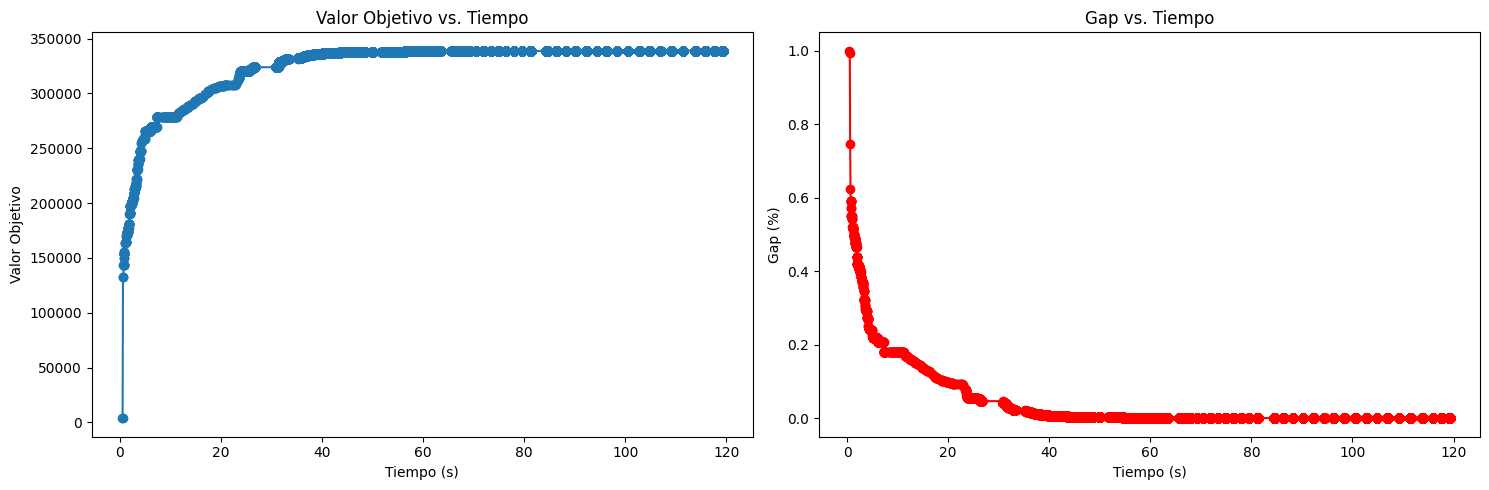

Bodega 8:  LON: -72.28493666107894, LAT: -36.94972320272767
Bodega 4:  LON: -71.19979328980153, LAT: -34.59885659314397
Bodega 1:  LON: -71.17766666666667, LAT: -30.56766666666668


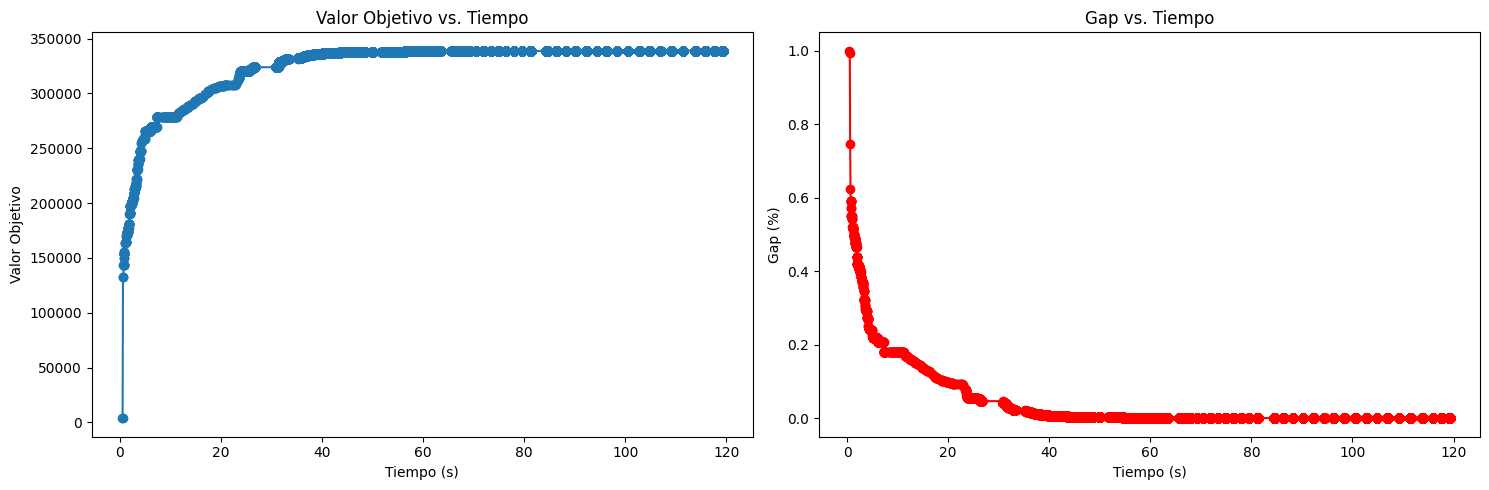

In [29]:
from modelos import Modelos

# Crear una instancia de la clase
instancia = Modelos('aloc', 'manhattan', proy=False) 

# Llamar al método resultados_aloc
instancia.resultados_aloc()

# Acceder a los resultados
resultados = instancia.resultados


In [43]:
lista = [2481, 859, 1782, 1954] #[1560, 1496, 2481, 1954, 1527, 906, 485]

In [44]:
def calcular_valor_objetivo_previo(diccionario_solucion, clientes_por_fecha_2, ida_o_vuelta):
    valor_objetivo_previo = 0

    if ida_o_vuelta == "ida":
        for fecha in clientes_por_fecha_2:
            for cliente in clientes_por_fecha_2[fecha]:
                if cliente["ID Cliente"] not in lista:
                    if diccionario_solucion[cliente["ID Cliente"]] != {}:
                        valor_objetivo_previo += diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]
                    else:
                        pass

    elif ida_o_vuelta == "vuelta":
        for fecha in clientes_por_fecha_2:
            for cliente in clientes_por_fecha_2[fecha] :
                if cliente["ID Cliente"] not in lista:
                    if diccionario_solucion[cliente["ID Cliente"]] != {}:
                        valor_objetivo_previo += diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]*2
                    else:
                        pass
        
    return valor_objetivo_previo

In [45]:
# Importo diccionario de solución
diccionario_solucion = resultados

# Calculo valor objetivo previo
calcular_valor_objetivo_previo(diccionario_solucion, clientes_por_fecha_2, "vuelta")

335359.71491854556

In [46]:
# Iteraciones
clientes_por_fecha = dict(clientes_por_fecha_2)

# La solución se guarda con diccionario por fecha
solucion_consolidacion = dict() 

In [47]:
def consolidacion(clientes_por_fecha, diccionario_solucion):

    for fecha in clientes_por_fecha: 
        solucion_fecha = list()
        for cliente in clientes_por_fecha[fecha]:
            if cliente["ID Cliente"] not in lista and diccionario_solucion[cliente["ID Cliente"]] != {}:
                if cliente['Categoria'] == "Premium":
                    
                    # Si es que no es primer cliente
                    if len(solucion_fecha) != 0:
                        cupo = False
                        for indice, camion in enumerate(solucion_fecha):

                            # Si cabe en algun camion, lo agrego
                            cliente_iteracion = [cliente["Cantidad"], cliente["ID Cliente"]]
                            cabe = cabe_en_camion(camion, cliente_iteracion)


                            if cabe[0] and diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"] == camion[2][0]:
                                solucion_fecha[indice][0] += cliente["Cantidad"]
                                solucion_fecha[indice][1] += cabe[1]
                                solucion_fecha[indice][2].append(cliente["ID Cliente"])
                                cupo = True
                                break
                        
                        if not cupo:
                            tiempo = diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]
                            solucion_fecha.append([cliente["Cantidad"], tiempo, [diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"], cliente["ID Cliente"]] ])
                    
                    # Si es que es primer cliente
                    else:
                        # Creo camión ############
                        tiempo = diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]
                        solucion_fecha.append([cliente["Cantidad"], tiempo, [diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"], cliente["ID Cliente"]] ])
            
        for cliente in clientes_por_fecha[fecha]:
            if cliente["ID Cliente"] not in lista and diccionario_solucion[cliente["ID Cliente"]] != {}:
                if cliente['Categoria'] == "Gold":
                    # Si es que no es primer cliente

                    if len(solucion_fecha) != 0:
                        cupo = False
                        for indice, camion in enumerate(solucion_fecha):

                            # Si cabe en algun camion, lo agrego
                            cliente_iteracion = [cliente["Cantidad"], cliente["ID Cliente"]]
                            cabe = cabe_en_camion(camion, cliente_iteracion)


                            if cabe[0] and diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"] == camion[2][0]:
                                solucion_fecha[indice][0] += cliente["Cantidad"]
                                solucion_fecha[indice][1] += cabe[1]
                                solucion_fecha[indice][2].append(cliente["ID Cliente"])
                                
                                cupo = True
                                break
                        
                        if not cupo:
                            tiempo = diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]
                            solucion_fecha.append([cliente["Cantidad"], tiempo, [diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"], cliente["ID Cliente"]] ])
                    
                    # Si es que es primer cliente
                    else:
                        # Creo camión ############
                        tiempo = diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]
                        solucion_fecha.append([cliente["Cantidad"], tiempo, [diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"], cliente["ID Cliente"]] ])

        for cliente in clientes_por_fecha[fecha]:
            if cliente["ID Cliente"] not in lista and diccionario_solucion[cliente["ID Cliente"]] != {}:
                if cliente['Categoria'] == "Silver":

                    # Si es que no es primer cliente
                    if len(solucion_fecha) != 0:
                        cupo = False
                        for indice, camion in enumerate(solucion_fecha):

                            # Si cabe en algun camion, lo agrego
                            cliente_iteracion = [cliente["Cantidad"], cliente["ID Cliente"]]
                            cabe = cabe_en_camion(camion, cliente_iteracion)

                            if cabe[0] and diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"] == camion[2][0]:
                                solucion_fecha[indice][0] +=  cliente["Cantidad"]
                                solucion_fecha[indice][1] += cabe[1]
                                solucion_fecha[indice][2].append(cliente["ID Cliente"])
                                cupo = True
                                break
                        
                        if not cupo:
                            tiempo = diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]
                            solucion_fecha.append([cliente["Cantidad"], tiempo, [diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"], cliente["ID Cliente"]] ])
                    
                    # Si es que es primer cliente
                    else:
                        # Creo camión ############
                        tiempo = diccionario_solucion[cliente["ID Cliente"]]["Tiempo"]
                        solucion_fecha.append([cliente["Cantidad"], tiempo, [diccionario_solucion[cliente["ID Cliente"]]["Bodega Asignada"], cliente["ID Cliente"]] ])
                
        solucion_consolidacion[fecha] = solucion_fecha   

    return solucion_consolidacion

In [48]:
consolidacion_vs_previo = dict()

clientes_por_fecha = dict(clientes_por_fecha_2)
solucion_consolidacion = consolidacion(clientes_por_fecha, diccionario_solucion)

valor_objetivo_consolidacion_ida = calcular_valor_objetivo_consolidacion(solucion_consolidacion, "ida")
valor_objetivo_previo_ida = calcular_valor_objetivo_previo(diccionario_solucion, clientes_por_fecha_2, "ida")
valor_objetivo_consolidacion_vuelta = calcular_valor_objetivo_consolidacion(solucion_consolidacion, "vuelta")
valor_objetivo_previo_vuelta = calcular_valor_objetivo_previo(diccionario_solucion, clientes_por_fecha_2, "vuelta")
camiones = calcular_camiones(solucion_consolidacion)

consolidacion_vs_previo = [valor_objetivo_consolidacion_ida, valor_objetivo_previo_ida, valor_objetivo_consolidacion_vuelta, valor_objetivo_previo_vuelta, camiones]

#### 2.3 Resultados

In [50]:

print("Valor objetivo consolidacion ida: ", consolidacion_vs_previo[0], "Valor objetivo previo:", consolidacion_vs_previo[1], "diferencia porcentual:", 100*round((consolidacion_vs_previo[0] - consolidacion_vs_previo[1])/consolidacion_vs_previo[1], 2))
print("Valor objetivo consolidacion vuelta: ", consolidacion_vs_previo[2], "Valor objetivo previo:", consolidacion_vs_previo[3], "diferencia porcentual:", 100*round((consolidacion_vs_previo[2] - consolidacion_vs_previo[3])/consolidacion_vs_previo[3], 2))


Valor objetivo consolidacion ida:  117190.50171357766 Valor objetivo previo: 167679.85745927278 diferencia porcentual: -30.0
Valor objetivo consolidacion vuelta:  183700.84282469004 Valor objetivo previo: 335359.71491854556 diferencia porcentual: -45.0


In [51]:
consolidacion_vs_previo[4] #36922

17404

In [52]:
len(dict_ventas)

65891